<a href="https://colab.research.google.com/github/mwalton/openspiel_benchmarks/blob/main/openspiel_reproductions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install wandb

In [2]:
import wandb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [16]:
class WandbRunGetter:
  def __init__(self, project):
    self._api = wandb.Api()
    runs = self._api.runs(project)

    self._project = project
    self._name_to_id = {}
    self._id_to_name ={}
    for r in runs:
      self._name_to_id[r.name] = r.id
      self._id_to_name[r.id] = r.name

  def get_runs(self, run_names, drop_metadata=True):
    configs = {}
    runs = {}
    for name, id in run_names:
      run_path = self._project + "/" + id
      
      run = self._api.run(run_path)
      scanner = run.scan_history()
      history = pd.DataFrame([row for row in scanner])
      
      if drop_metadata:
        metadata_cols = [c for c in history.columns if c[0] == "_"]
      history = history.drop(metadata_cols, axis=1)

      configs[name] = run.json_config
      runs[name] = history
    return configs, runs

  def load_experiment(self, run_names=None, target_names=None,
                    units="Exploitability", interpolate=True):
    runs = {}
    targets = {}
    if not run_names is None:
      configs, runs = self.get_runs(run_names)
    if not target_names is None:
      targets = get_targets(target_names)

    runs = join_runs({**targets, **runs}, units=units)
    if interpolate:
      runs = log_interp(runs)
    
    return runs

def join_runs(runs, set_idx=True, units=None):
  assert(units in [None, "Exploitability", "NashConv", "Milliblinds"])
  df = pd.DataFrame()
  for name, dat in runs.items():
    if set_idx:
      dat = dat.set_index('Iteration')
    if "NashConv" in dat.columns:
      dat = dat.rename(columns={'NashConv': name})
      if units == "Exploitability":
        dat[name] /= 2
      elif units == "Milliblinds":
        dat[name] *= 500
    elif "Exploitability" in dat.columns:
      dat = dat.rename(columns={'Exploitability': name})
      if units == "NashConv":
        dat[name] *= 2
      elif units == "Milliblinds":
        dat[name] *= 1000
    elif "Milliblinds" in dat.columns:
      dat = dat.rename(columns={'Milliblinds': name})
      if units == "NashConv":
        dat[name] /= 500
      elif units == "Exploitability":
        dat[name] /= 1000
    else:
      raise ValueError("Invalid units")
    df = df.join(dat, how="outer")

  return df

def get_targets(targets):
  runs = {}
  for name, path in targets:
    runs[name] = pd.read_csv(path)
  return runs

def log_interp(df, method="index"):
  # linear interpolation in logspace
  df.index += 1
  df.index = df.index.map(np.log)
  df = df.apply(np.log)

  df = df.interpolate(method=method)

  df.index = df.index.map(np.exp)
  df = df.apply(np.exp)
  df.index -= 1
  return df

In [4]:
def plot(dat, ax, target_match_color=False, ub_color=False, loglog=True,
         title=None, ylabel=None, xlabel=None, style="seaborn-ticks"):
  plt.style.use(style)
  colors = {}
  for col in dat.columns:
    if not "Target" in col:
      dat[col].plot(ax=ax, loglog=loglog)
      colors[col] = ax.get_lines()[-1].get_color()

  for col in dat.columns:
    if "Target" in col:
      if target_match_color:
        c = colors[col.split(" Target")[0]]
      elif ub_color:
        if "Upper" in col:
          c = 'r'
        elif "Lower" in col:
          c = 'g'
      else:
        c = "gray"
      dat[col].plot(style=":", c=c, ax=ax, loglog=loglog)

  ax.set_title(title)
  ax.set_ylabel(ylabel)
  ax.set_xlabel(xlabel)
  ax.legend()

In [5]:
run_getter = WandbRunGetter("mwalton/openspiel")

In [50]:


targets = {"cfr_kuhn": "https://raw.githubusercontent.com/mwalton/openspiel_benchmarks/main/target_results/cfr_kuhn.csv",
           "cfr_leduc": "https://raw.githubusercontent.com/mwalton/openspiel_benchmarks/main/target_results/cfr_leduc.csv",
           "xfp_kuhn": "https://raw.githubusercontent.com/mwalton/openspiel_benchmarks/main/target_results/xfp_kuhn.csv",
           "xfp_leduc": "https://raw.githubusercontent.com/mwalton/openspiel_benchmarks/main/target_results/xfp_leduc.csv",
           "nned_leduc": "https://raw.githubusercontent.com/mwalton/openspiel_benchmarks/main/target_results/nned_leduc.csv",
           "nfsp_leduc_hs_16": "https://raw.githubusercontent.com/mwalton/openspiel_benchmarks/main/target_results/nfsp_leduc_heinrich_silver_16.csv",
           "nfsp_leduc_hs_128": "https://raw.githubusercontent.com/mwalton/openspiel_benchmarks/main/target_results/nfsp_leduc_heinrich_silver_128.csv",
           "nfsp_leduc_os": "https://raw.githubusercontent.com/mwalton/openspiel_benchmarks/main/target_results/nfsp_leduc_os.csv",
           "qpg_kuhn": "https://raw.githubusercontent.com/mwalton/openspiel_benchmarks/main/target_results/qpg_srinivasan_kuhn.csv",
           "qpg_leduc": "https://raw.githubusercontent.com/mwalton/openspiel_benchmarks/main/target_results/qpg_srinivasan_leduc.csv",
           "rpg_kuhn": "https://raw.githubusercontent.com/mwalton/openspiel_benchmarks/main/target_results/rpg_srinivasan_kuhn.csv",
           "rpg_leduc": "https://raw.githubusercontent.com/mwalton/openspiel_benchmarks/main/target_results/rpg_srinivasan_leduc.csv",
           "cfr_leduc_os": "https://raw.githubusercontent.com/mwalton/openspiel_benchmarks/main/target_results/cfr_leduc_os.csv",
           "rcfr_leduc_os": "https://raw.githubusercontent.com/mwalton/openspiel_benchmarks/main/target_results/rcfr_leduc_os.csv",
           "rcfr_leduc_waugh_22": "https://raw.githubusercontent.com/mwalton/openspiel_benchmarks/main/target_results/rcfr_leduc_waugh_22.csv",
           "rcfr_leduc_waugh_95": "https://raw.githubusercontent.com/mwalton/openspiel_benchmarks/main/target_results/rcfr_leduc_waugh_95.csv",
           "deep_cfr_leduc": "https://raw.githubusercontent.com/mwalton/openspiel_benchmarks/main/target_results/deep_cfr_leduc.csv",
           "psro_leduc": "https://raw.githubusercontent.com/mwalton/openspiel_benchmarks/main/target_results/psro_leduc.csv",
           "ppsro_leduc": "https://raw.githubusercontent.com/mwalton/openspiel_benchmarks/main/target_results/ppsro_leduc.csv",
           "naive_psro_leduc": "https://raw.githubusercontent.com/mwalton/openspiel_benchmarks/main/target_results/naive_psro_leduc.csv",
           "neurd_leduc": "https://raw.githubusercontent.com/mwalton/openspiel_benchmarks/main/target_results/neurd_leduc.csv",
           }

# Counterfactual Regret Minimisation

Text(0.06, 0.5, 'Exploitability')

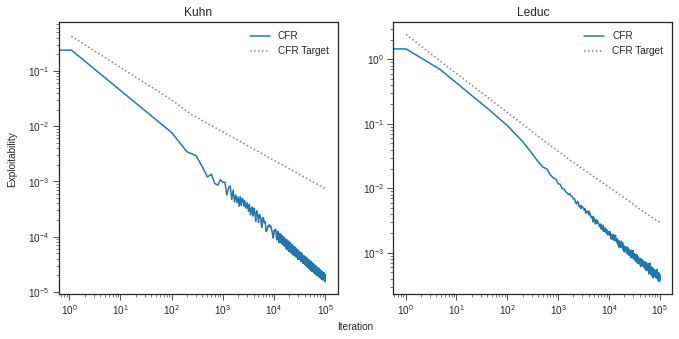

In [19]:
cfr_kuhn = run_getter.load_experiment([("CFR", "1ip4yhwa")],
                                      [("CFR Target", targets["cfr_kuhn"])])
cfr_leduc = run_getter.load_experiment([("CFR", "3mui4cj2")],
                                       [("CFR Target", targets["cfr_leduc"])])

fig, ax = plt.subplots(1,2,figsize=(11,5))
plot(cfr_kuhn, ax[0], title="Kuhn")
plot(cfr_leduc, ax[1], title="Leduc")
fig.text(0.5, 0.025, 'Iteration', ha='center')
fig.text(0.06, 0.5, 'Exploitability', va='center', rotation='vertical')

# Extensive-form Fictitious Self Play

Text(0.06, 0.5, 'Exploitability')

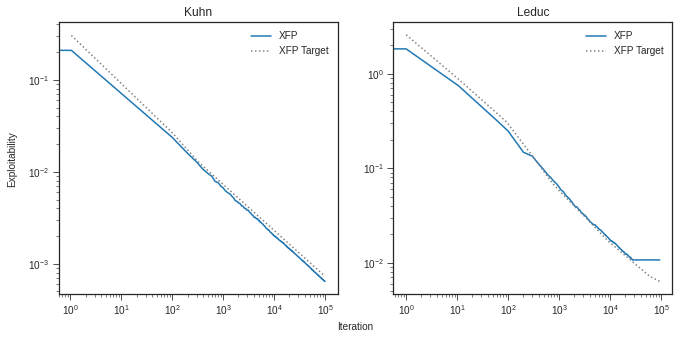

In [8]:
xfp_kuhn = run_getter.load_experiment([("XFP", "2rdcw4m2")], 
                                      [("XFP Target", targets["xfp_kuhn"])])
xfp_leduc = run_getter.load_experiment([("XFP", "2q597ej2")],
                                       [("XFP Target", targets["xfp_leduc"])])

fig, ax = plt.subplots(1,2,figsize=(11,5))
plot(xfp_kuhn, ax[0], title="Kuhn")
plot(xfp_leduc, ax[1], title="Leduc")
fig.text(0.5, 0.025, 'Iteration', ha='center')
fig.text(0.06, 0.5, 'Exploitability', va='center', rotation='vertical')

# Neural Fictitous Self-Play

Text(0.06, 0.5, 'Exploitability')

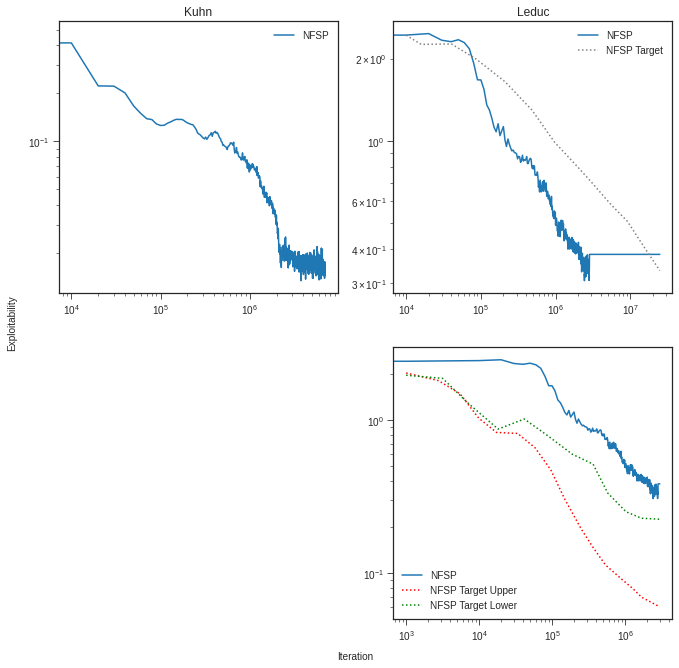

In [9]:
nfsp_kuhn = run_getter.load_experiment([("NFSP", "2quwzzjm")])
nfsp_leduc_os = run_getter.load_experiment([("NFSP", "3tjqval8")],
                                           [("NFSP Target", targets["nfsp_leduc_os"])])
nfsp_leduc_hs = run_getter.load_experiment([("NFSP", "3tjqval8")],
                                           [("NFSP Target Upper", targets["nfsp_leduc_hs_128"]),
                                            ("NFSP Target Lower", targets["nfsp_leduc_hs_16"])
                                            ])

fig, ax = plt.subplots(2,2,figsize=(11,11))
ax[1,0].set_visible(False)
plot(nfsp_kuhn, ax[0,0], title="Kuhn")
plot(nfsp_leduc_os, ax[0,1], title="Leduc")
plot(nfsp_leduc_hs, ax[1,1], ub_color=True)
fig.text(0.5, 0.075, 'Iteration', ha='center')
fig.text(0.06, 0.5, 'Exploitability', va='center', rotation='vertical')

# Policy Gradient

Text(0.06, 0.5, 'Exploitability')

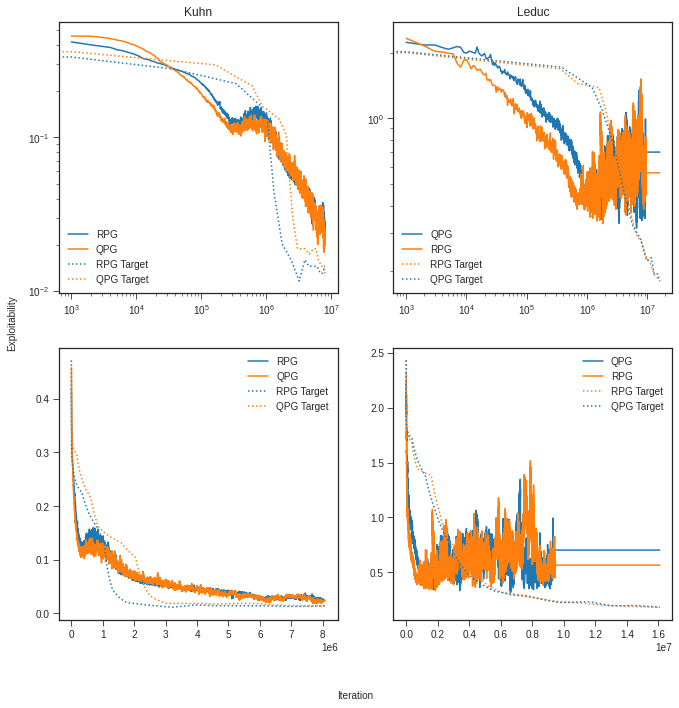

In [15]:
pg_kuhn = run_getter.load_experiment([("RPG", "26y08y9f"),
                                     ("QPG", "19r7usdu")],
                                      [("RPG Target", targets["rpg_kuhn"]),
                                       ("QPG Target", targets["qpg_kuhn"])])
pg_leduc = run_getter.load_experiment([("QPG", "g0v7fuyt"),
                                       ("RPG", "1uaa8rt8")],
                                       [("RPG Target", targets["rpg_leduc"]),
                                        ("QPG Target", targets["qpg_leduc"])])

fig, ax = plt.subplots(2,2,figsize=(11,11))
plot(pg_kuhn, ax[0,0], title="Kuhn", target_match_color=True)
plot(pg_leduc, ax[0,1], title="Leduc", target_match_color=True)
plot(pg_kuhn, ax[1,0], target_match_color=True, loglog=False)
plot(pg_leduc, ax[1,1], target_match_color=True, loglog=False)
fig.text(0.5, 0.025, 'Iteration', ha='center')
fig.text(0.06, 0.5, 'Exploitability', va='center', rotation='vertical')

# Regression CFR

Text(0.06, 0.5, 'Exploitability')

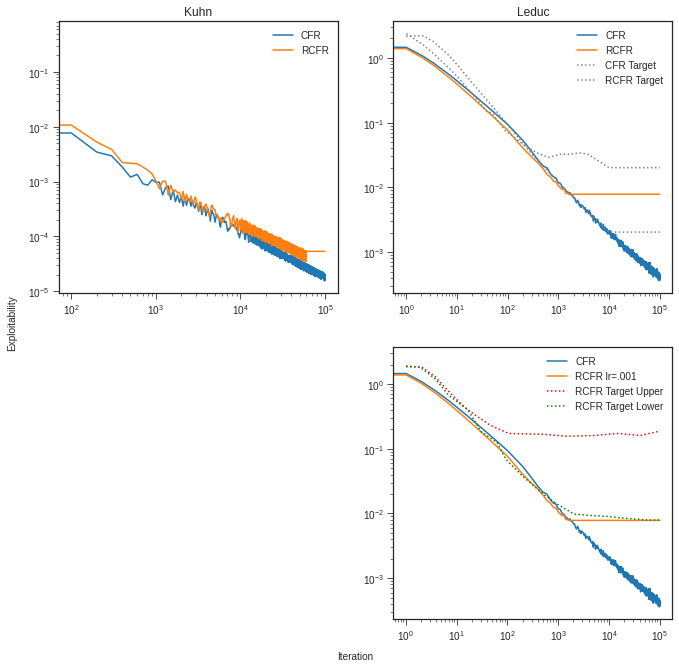

In [33]:
rcfr_kuhn = run_getter.load_experiment([("CFR", "1ip4yhwa"),
                                        ("RCFR", "15bzruml")])
rcfr_leduc_os = run_getter.load_experiment([("CFR", "3mui4cj2"), ("RCFR", "3hhjph04")],
                                           [("CFR Target", targets["cfr_leduc_os"]),
                                            ("RCFR Target", targets["rcfr_leduc_os"])])
rcfr_leduc_w = run_getter.load_experiment([("CFR", "3mui4cj2"), ("RCFR lr=.001", "3hhjph04")],
                                           [("RCFR Target Upper", targets["rcfr_leduc_waugh_22"]),
                                            ("RCFR Target Lower", targets["rcfr_leduc_waugh_95"])
                                            ])

# correction for nashconv err, remove if not using runs 15bzruml or 3hhjph04
rcfr_kuhn["RCFR"] *= 2
rcfr_leduc_os["RCFR"] *= 2
rcfr_leduc_w["RCFR lr=.001"] *= 2

fig, ax = plt.subplots(2,2,figsize=(11,11))
ax[1,0].set_visible(False)
plot(rcfr_kuhn, ax[0,0], title="Kuhn")
plot(rcfr_leduc_os, ax[0,1], title="Leduc")
plot(rcfr_leduc_w, ax[1,1], ub_color=True)
fig.text(0.5, 0.075, 'Iteration', ha='center')
fig.text(0.06, 0.5, 'Exploitability', va='center', rotation='vertical')

# Deep CFR

Text(0.06, 0.5, 'Exploitability')

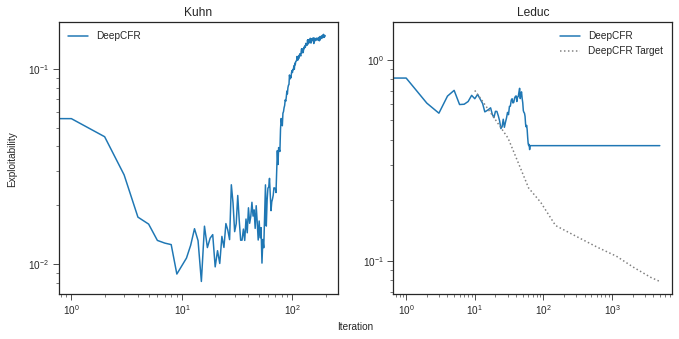

In [36]:
deep_cfr_kuhn = run_getter.load_experiment([("DeepCFR", "1ndrs79w")])
deep_cfr_leduc = run_getter.load_experiment([("DeepCFR", "29rq9ozq")],
                                       [("DeepCFR Target", targets["deep_cfr_leduc"])])

fig, ax = plt.subplots(1,2,figsize=(11,5))
plot(deep_cfr_kuhn, ax[0], title="Kuhn")
plot(deep_cfr_leduc, ax[1], title="Leduc")
fig.text(0.5, 0.025, 'Iteration', ha='center')
fig.text(0.06, 0.5, 'Exploitability', va='center', rotation='vertical')

# Policy Space Response Oracles

Text(0.06, 0.5, 'Exploitability')

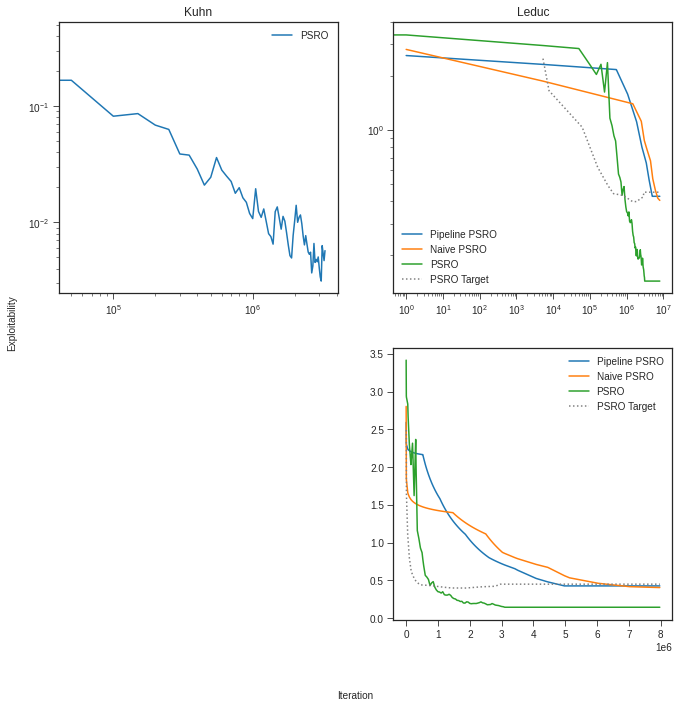

In [49]:
psro_kuhn = run_getter.load_experiment([("PSRO", "1jnwtkm4")])
psro_leduc = run_getter.load_experiment([("PSRO", "jdg14toh")],
                                       [("PSRO Target", targets["psro_leduc"]),
                                        ("Pipeline PSRO", targets["ppsro_leduc"]),
                                        ("Naive PSRO", targets["naive_psro_leduc"])
                                        ])

#psro_leduc["PSRO"] *= 2

fig, ax = plt.subplots(2,2,figsize=(11,11))
plot(psro_kuhn, ax[0,0], title="Kuhn")
plot(psro_leduc, ax[0,1], title="Leduc")
plot(psro_leduc, ax[1,1], loglog=False)
ax[1,0].set_visible(False)
fig.text(0.5, 0.025, 'Iteration', ha='center')
fig.text(0.06, 0.5, 'Exploitability', va='center', rotation='vertical')

# Exploitability Descent

Text(0.06, 0.5, 'Exploitability')

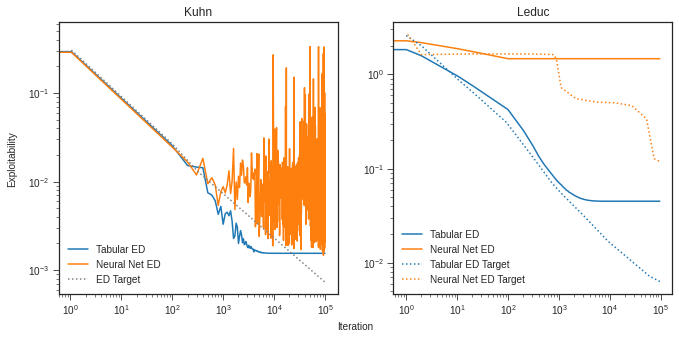

In [34]:
ed_kuhn = run_getter.load_experiment([("Tabular ED", "3s9h5zqw"),
                                      ("Neural Net ED", "3rsebdfi")],
                                     [("ED Target", targets["xfp_kuhn"])])
ed_leduc = run_getter.load_experiment([("Tabular ED", "2qxn1rxk"),
                                        ("Neural Net ED", "2fl6kfmk")],
                                      [("Tabular ED Target", targets["xfp_leduc"]),
                                       ("Neural Net ED Target", targets["nned_leduc"])])

fig, ax = plt.subplots(1,2,figsize=(11,5))
plot(ed_kuhn, ax[0], title="Kuhn")
plot(ed_leduc, ax[1], title="Leduc", target_match_color=True)
fig.text(0.5, 0.025, 'Iteration', ha='center')
fig.text(0.06, 0.5, 'Exploitability', va='center', rotation='vertical')

# Neural Replicator Dynamics

Text(0.06, 0.5, 'Exploitability')

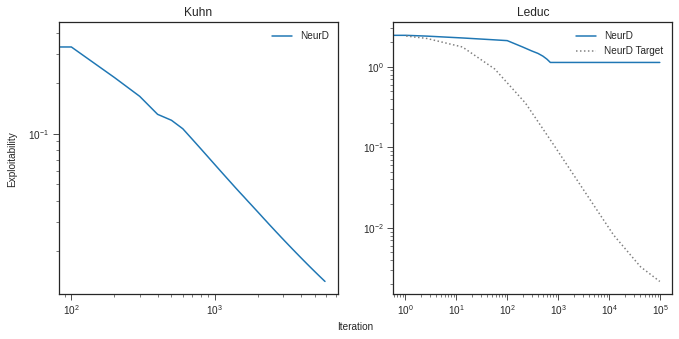

In [57]:
neurd_kuhn = run_getter.load_experiment([("NeurD", "16vmwp2l")])
neurd_leduc = run_getter.load_experiment([("NeurD", "32xlprp3")],
                                       [("NeurD Target", targets["neurd_leduc"])])

fig, ax = plt.subplots(1,2,figsize=(11,5))
plot(neurd_kuhn, ax[0], title="Kuhn")
plot(neurd_leduc, ax[1], title="Leduc")
fig.text(0.5, 0.025, 'Iteration', ha='center')
fig.text(0.06, 0.5, 'Exploitability', va='center', rotation='vertical')